# Distinguish cardiologists from the general providers
### Author: Weiwei Ouyang
### Date: 01/12/2020

### Dataset:
* **npi_proc_counts.csv(Medicare Procedure Claims)**
* **npi_drugs.csv(Medicare Pharmacy Claims)**
* **hcpcs_lookup.csv(HCPCS codes)**
* **npi_specialty.csv (Provider type)**

### Steps:
* **Load the packages and the raw tables (4 tables)**
* **Preprocess npi_specialty table and get the outcomes (Whether cardiologist or not)**
* **Preprocess the procedure claim (Get the procedure group features and corresponding average service numbers)**
* **Preprocess the pharmacy claim (Get the procedure group features and corresponding average drug numbers)**
* **Get the merged table with outcomes and corresponding procedure and drug columns**
* **Feature Analysis, Engineering and Selection**
* **Apply Machine Learning Methods and Model Comparisons and Evaluations**
* **Conclusion and Discussions**

## Load the packages

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.metrics import recall_score,classification_report
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import roc_auc_score,f1_score,recall_score,precision_score,average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import GridSearchCV
from pandas_ply import install_ply, X, sym_call #Similar funtion like %>% in R
install_ply(pd)
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

## Load the datasets

In [2]:
claim = pd.read_csv('npi_proc_counts.csv')
rx_claim=pd.read_csv('npi_drugs.csv')
HCPC=pd.read_csv('hcpcs_lookup.csv')
provider=pd.read_csv('npi_specialty.csv')

## Preprocess the outcome dataset

Since we want to distinguish cardiologists from others, we can transform it to a binary classification problem and generate a new column to indicate whether this provider is cardiologist or not

**Generate a new column 'cardi_flag' to indicate whether the provider is cardiologist and drop duplicates**

In [3]:
provider['cardi_flag']=provider.specialty.str.contains('Cardiology').astype(int)
provider.drop_duplicates(inplace=True)

**Calculate the rate of cardiologist**

In [4]:
print("In total, there are {} providers and {}% are cardiologists".format(provider.shape[0],provider.cardi_flag.mean()*100))

In total, there are 909605 providers and 2.475140308155738% are cardiologists


2.48% of all providers are cardiologists. 

In [5]:
#only keep the flag column and the NPI code as primary key to join other tables later
provider=provider[['NPI','cardi_flag']]

In [6]:
#provider.shape
#provider.NPI.nunique() 
#Check whether NPI is unique and there are no duplicate NPI codes

In [7]:
provider.head(3)

,NPI,cardi_flag
0,1003000126,0
1,1003000134,0
2,1003000142,0


**provider** can be our main table and left join other tables. To narrow down the procedure and drug types, we only keep the procedures and drugs that cardiologists used and narrow down the columns in the datatable.

## Preprocess the claim data(long-format to wide-format)

There are too many procedures in procedure claim table and we narrow down to the most common procedures cardiologists will have. Below are the following steps(In practice, B and C can reverse order sometimes):

**A. Narrow down to procedures cardiologists would have.**

**B.Generate wide-format table with colums contain all procedures and corresponding procedure numbers.**

**C.Choose a cut-off and only choose the most common single procedures.**

**D.Use clinical domain knowledge to generate aggrigate fianl features for modeling (HCPC table).**

In [8]:
print('In total, there are {} unique procedures in claim table while the numbers of unique procedures among cardiologists are {}'.format(claim.HCPCS_CODE.nunique(),claim[claim.NPI.isin(provider[provider.cardi_flag==1].NPI)].HCPCS_CODE.nunique()))

In total, there are 5983 unique procedures in claim table while the numbers of unique procedures among cardiologists are 1339


### A. Narrow down to procedures cardiologists would have

In [9]:
%%time
claim=claim[claim.HCPCS_CODE.isin(list(set(claim[claim.NPI.isin(provider[provider.cardi_flag==1].NPI)].HCPCS_CODE)))]

CPU times: user 1.12 s, sys: 337 ms, total: 1.46 s
Wall time: 1.47 s


The total numbers for each procedure may depend on the number of members who received the service. Thus we are more interesetd in the average number of services one member received for each service.

**Remove duplicates**

In [10]:
#claim.drop_duplicates()
#claim.shape
# There exist duplicates. 7899575----> 7898099
claim=claim.drop_duplicates()

In [11]:
claim.shape

(7898099, 4)

**Calculate the average number for each procedure (Get long-format table)**

In [12]:
claim_long=claim.groupby(['NPI','HCPCS_CODE']).ply_select(AVG_SRVC=X.LINE_SRVC_CNT.sum()/X.BENE_UNIQUE_CNT.sum(),
                                                         SRVC_Count=X.LINE_SRVC_CNT.sum(),
                                                         MEMBER_Count=X.BENE_UNIQUE_CNT.sum()).reset_index()
claim_long.head(3)

,NPI,HCPCS_CODE,AVG_SRVC,SRVC_Count,MEMBER_Count
0,1003000126,99222,1.028986,142,138
1,1003000126,99223,1.010526,96,95
2,1003000126,99231,1.297872,61,47


In [13]:
del claim

In [14]:
#claim[claim.HCPCS_CODE.str.contains('[A-Z]')].HCPCS_CODE

**B. Generate wide-format table with colums contain all procedures and corresponding procedure numbers**

In [15]:
%%time
claim_wide_Avg=claim_long.pivot(index='NPI', columns='HCPCS_CODE', values='AVG_SRVC')
#claim_wide_SRVC=claim_long.pivot(index='NPI', columns='HCPCS_CODE', values='SRVC_Count')
#claim_wide_MEMBER=claim_long.pivot(index='NPI', columns='HCPCS_CODE', values='MEMBER_Count')

CPU times: user 8.94 s, sys: 10.6 s, total: 19.6 s
Wall time: 21.1 s


In [16]:
claim_wide_Avg.head(1)

HCPCS_CODE,00142,00300,00320,00400,00410,00537,00541,00560,00562,00567,...,Q2039,Q3014,Q4102,Q9956,Q9957,Q9963,Q9965,Q9966,Q9967,Q9969
NPI,,,,,,,,,,,,,,,,,,,,,
1003000126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are many missing values in each columns, next we need to filter the procedure with too many missing rows(At least Non-Missing>=2.5%). Missing values mean the provider didn't apply this procedure. The reason we choose 2.5% as cut-off due to the cardilogist rate. 

**Generate Non-Missing value percentage table**

In [17]:
%%time
#Miss=claim_wide.isnull().sum(axis=0)
Miss=pd.DataFrame([(x,y) for x,y in claim_wide_Avg.isnull().sum(axis=0).items()],columns=['HCPCS_CODE','Miss_Count'])
Miss['Non_Miss_Per']=1-Miss['Miss_Count']/claim_wide_Avg.shape[0]
#Keep_Proc=list(Miss[Miss.Miss_Per<0.05].HCPCS_CODE)

CPU times: user 12.3 s, sys: 11.6 s, total: 23.9 s
Wall time: 26.4 s


In [18]:
Miss.head(1)

,HCPCS_CODE,Miss_Count,Non_Miss_Per
0,00142,813427,0.027703


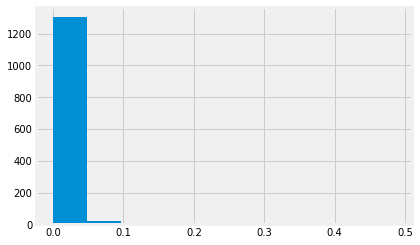

In [19]:
Miss.Non_Miss_Per.hist()

If we look at procedure one by one, the majority of non-missing percentage is smaller than 10%. 

### C. Choose a cut-off and only choose the most common single procedures

If we consider procedure one by one, we need to filter the procedure with too many missing rows(At least Non-Missing>=2.5%). The reason we choose 2.5% as cut-off due to the cardilogist rate (2.48%). 

**Show the procedures with non-missing percentage no smaller than 2.5%**

In [20]:
pd.set_option('display.max_rows', None)
Keep_Procedure=list(Miss[Miss.Non_Miss_Per>=0.025].HCPCS_CODE)
HCPC[HCPC.HCPCS_CODE.isin(Keep_Procedure)].sort_index()

,HCPCS_CODE,HCPCS_DESCRIPTION
6,00142,Anesthesia for lens surgery
62,00740,Anesthesia for procedure on gastrointestinal t...
76,00810,Anesthesia for procedure on lower intestine us...
436,17000,Destruction of skin growth
531,20610,Aspiration or injection of large joint or join...
1601,36415,Insertion of needle into vein for collection o...
2943,69210,Removal of impact ear wax
3010,70450,CT scan head or brain
3040,71010,"X-ray of chest, 1 view, front"
3042,71020,"X-ray of chest, 2 views, front and side"


In [21]:
print('There are {} procedures with non-missing percentage no smaller than 2.5% and displayed above'.format(len(Keep_Procedure)))

There are 78 procedures with non-missing percentage no smaller than 2.5% and displayed above


### D. Use clinical domain knowledge to generate final aggrigate features for modeling (HCPC table)

The assumption we use here is: The higher the non-missing percentage is, the more commonly applied the procedures would be by providers. 

Since we don't have lots of clinical domain knowledge, we can use the 78 procedures we get in **Section C** to have an general understanding of what procedures the providers may have. From the table above, we can aggregate all to the following up procedure categories that may be useful for folow-up modeling step:


| Feature       | Description                            | Generation                                                                                                                |
|---------------|----------------------------------------|---------------------------------------------------------------------------------------------------------------------------|
| Anes          | Anesthesia |     See additonal note                                                                                                                 |
| skin          | Destruction of skin growth             | ['17000','17003','17004','17106','17107','17108','17110','17111']                                                         |
| Asp           | Aspiration or injection                | ['20600','20605','20610','20612','20615']                                                                                 |
| Insert_Vein   | Insertion of needle into vein          | ['36410','36415']                                                                                                         |
| Ear           | Removal of ear-related parts           | ['69110','69120','69140','69145','69200','69205','69210']                                                                 |
| CT_head       | CT scan head-related parts             | ['70450','70460','70470']                                                                                                 |
| Xray_chest    | X-ray of chest                         | ['71010','71015','71020','71021','71022','71023','71030','71034','71035']                                                 |
| Xray_spline   | X-ray of spline-related parts          | ['72010','72020','72040','72050','72052','72069','72070','72072','72074','72080','72090','72100','72110','72114','72120'] |
| Xray_pelvis   | X-ray of pelvis parts                  | ['72170','72190']                                                                                                         |
| Xray_shoulder | X-ray of shoulder                      | ['73010','73020','73030']                                                                                                 |
| Xray_hip      | X-ray of hip parts                     | ['73500','73510','73520','73525','73530','73540']                                                                         |
| Xray_knee     | X-ray of knee parts                    | ['73560','73562','73564','73565','73580']                                                                                 |
| Xray_ankle    | X-ray of ankle parts                   | ['73600','73610','73615']                                                                                                 |
| Xray_foot     | X-ray of foot parts                    | ['73620','73630']                                                                                                         |
| Xray_abd      | X-ray of abdomen                       | ['74000','74010','74020','74022']                                                                                         |
| CT_abd        | CT scan of abdomen                     | ['74150','74160','74170','74176','74177','74178']                                                                         |
| Ultra_g       | Ultrasonic guidance                    |['76930','76932','76936','76937','76940','76942','76950','76965','76998']                                                                                           |
| Inject_T      | Injection Tissue Related               | ['96372','96373','96374','96375','96379']                                                                                 |
| Bone          | Bone Related                           | ['77078','77080','77081','77082','77084']                                                                                 |
| BT            | Blood Test                             | ['80047','80048','80051','80053','80061']                                                                                 |
| Urine         | Urine test                             | ['81000','81001','81002','81003','81005','81007','81015','81020','81025','81050','81099']                                 |
| Hemo          | Hemoglobin Related                     | ['83020','83021','83026','83036','83037']                                                                                 |
| BT_TSH        | Blood test TSH                         | ['84443']                                                                                                                 |
| B_Count       | Blood Cell Count                       | ['85025','85027']                                                                                                         |
| BT_Clot       | Blood Test clotting time               | ['85610','85611']                                                                                                         |
| Vac_influ     | Vaccine for influenza virus            | ['90653','90654','90655','90656','90657','90660','90661','90662']                                                         |
| Vac_pneu      | Vaccine for pneumococcal               | ['90732']                                                                                                                 |
| EKG           | Routine EKG                            | ['93000','93005','93010']                                                                                                 |
| Ultra_heart   | Ultrasound Exam of Heart-related parts | ['93303','93304','93306','93307','93308']                                                                                 |
| Ultra_head    | Ultrasound Exam of head-related parts  | ['93880','93882','93886','93888']                                                                                         |
| Ultra_arm     | Ultrasound Exam of arms or legs        | ['93965','93970','93971']                                                                                                 |
| Inject_prev   | Injection for prevention               | ['96372','96373','96374','96375','96379']                                                                                 |
| Phy_therapy   | Physical therapy evaluation            | ['97001','97002']                                                                                                         |
| Ther_Ex       | Therapeutic exercise                   | ['97110','97112','97113','97116','97124','97139','97140','97150','97530']                                                            |
| New_OP        | New Outpatient Visits                  | ['99201','99202','99203','99204','99205']                                                                                 |
| Est_OP        | Established Outpatient visits          | ['99211','99212','99213','99214','99215']                                                                                 |
| Hos_care      | Hospital obeservation care             | ['99217','99218','99219','99220']                                                                                         |
| Ini_IP        | Initial Inpatient Care                 | ['99221','99222','99223']                                                                                                 |
| Sub_IP        | Subsequent hospital inpatient care     | ['99231','99232','99233']                                                                                                 |
| Hos_Dis       | Hospital Discharge manage              | ['99238','99239']                                                                                                         |
| ED            | Emergency visits                       | ['99281','99282','99283','99284','99285']                                                                                 |
| CD            | Critical care delivery                 | ['99291','99292']                                                                                                         |
| Ini_Nurse     | Initial nursing visit                  | ['99304','99305','99306']                                                                                                 |
| Sub_Nurse     | Subsequent nursing visit               | ['99307','99308','99309','99310']                                                                                         |
| Admin_Vac     | Administration of vaccine              | ['G0008','G0009','G0010']                                                                                                 |
| Cervial       | Cervial Cancer Screen                  | ['G0101']                                                                                                                 |
| Home          | Home health                            | ['G0179','G0180','G0181','G0182']                                                                                         |
| Wellness      | Annual wellness visit                  | ['G0438','G0439']                                                                                                         |
| Triamc        | Injection of triamcinolone-related     | ['J3300','J3301','J3302','J3303']                                                                                         |
| Influ_Vac     | Influenza virus vaccine                | ['Q2034','Q2035','Q2036','Q2037','Q2038','Q2039']                                                                         |

Additonal Note:

['00100','00103','00104','00120','00126','00140','00142','00144','00145','00147','00148','00160','00164','00170','0190','00210','00211','00216','00220','00222','00300','00320','00350','00352','00400','00402','00404','00406','00410','00500','00520','00522','00528','00529','00530','00532','00534','00537','00540','00541','00542','00550','00560','00562','00563','00566','00567','00580','00600','00604','00620','00630','00635','00640','00670','00700',
'00702','00730','00740','00750','00752','00770','00790','00792','00794','00796','00797','00800','00810','00820',
'00830','00832','00840','00844','00846','00860','00862','00864','00865','00868','00870','00872','00873','00880',
'00882','00902','00904','00910','00912','00914','00916','00918','00920','00938','00940','00942','00944','00952',
'01112','01120','01160,'01170','01200','01202','01210','01214','01215','01220','01230','01232,'01250','01260','01270','01272','01320','01380','01382','01392','01400','01402','01430','01462','01470','01474','01480','01482','01486',
'01500','01520','01610','01620','01622','01630','01638','01670,'01710','01716'] 

**Generate raw aggregate feature dictionary**

In [22]:
Raw_Agg_Feature_dic={
'Anes':['00100','00103','00104','00120','00126','00140','00142','00144','00145','00147','00148','00160','00164','00170','00190','00210','00211','00216','00220','00222','00300','00320','00350','00352','00400','00402','00404','00406','00410','00500','00520','00522','00528','00529','00530','00532','00534','00537','00540','00541','00542','00550','00560','00562','00563','00566','00567','00580','00600','00604','00620','00630','00635','00640','00670','00700', '00702','00730','00740','00750','00752','00770','00790','00792','00794','00796','00797','00800','00810','00820', '00830','00832','00840','00844','00846','00860','00862','00864','00865','00868','00870','00872','00873','00880', '00882','00902','00904','00910','00912','00914','00916','00918','00920','00938','00940','00942','00944','00952','01112','01120','01160','01170','01200','01202','01210','01214','01215','01220','01230','01232','01250','01260','01270','01272','01320','01380','01382','01392','01400','01402','01430','01462','01470','01474','01480','01482','01486', '01500','01520','01610','01620','01622','01630','01638','01670','01710','01716'],
'skin':['17000','17003','17004','17106','17107','17108','17110','17111'],
'Asp':['20600','20605','20610','20612','20615'],
'Insert_Vein':['36410','36415'],
'Ear':['69110','69120','69140','69145','69200','69205','69210'],
'CT_head':['70450','70460','70470'],
'Xray_chest':['71010','71015','71020','71021','71022','71023','71030','71034','71035'],
'Xray_spline':['72010','72020','72040','72050','72052','72069','72070','72072','72074','72080','72090','72100','72110','72114','72120'],
'Xray_pelvis':['72170','72190'],
'Xray_shoulder':['73010','73020','73030'],
'Xray_hip':['73500','73510','73520','73525','73530','73540'],
'Xray_knee':['73560','73562','73564','73565','73580'],
'Xray_ankle':['73600','73610','73615'],
'Xray_foot':['73620','73630'],
'Xray_abd':['74000','74010','74020','74022'],
'CT_abd':['74150','74160','74170','74176','74177','74178'],
'Ultra_g':['76930','76932','76936','76937','76940','76942','76950','76965','76998'],
'Inject_T':['96372','96373','96374','96375','96379'],
'Bone':['77078','77080','77081','77082','77084'],
'BT':['80047','80048','80051','80053','80061'],
'Urine':['81000','81001','81002','81003','81005','81007','81015','81020','81025','81050','81099'],
'Hemo':['83020','83021','83026','83036','83037'],
'BT_TSH':['84443'],
'B_Count':['85025','85027'],
'BT_Clot':['85610','85611'],
'Vac_influ':['90653','90654','90655','90656','90657','90660','90661','90662'],
'Vac_pneu':['90732'],
'EKG':['93000','93005','93010'],
'Ultra_heart':['93303','93304','93306','93307','93308'],
'Ultra_head':['93880','93882','93886','93888'],
'Ultra_arm':['93965','93970','93971'],
'Inject_prev':['96372','96373','96374','96375','96379'],
'Phy_therapy':['97001','97002'],
'Ther_Ex':['97110','97112','97113','97116','97124','97139','97140','97150','97530'],
'New_OP':['99201','99202','99203','99204','99205'],
'Est_OP':['99211','99212','99213','99214','99215'],
'Hos_care':['99217','99218','99219','99220'],
'Ini_IP':['99221','99222','99223'],
'Sub_IP':['99231','99232','99233'],
'Hos_Dis':['99238','99239'],
'ED':['99281','99282','99283','99284','99285'],
'CD':['99291','99292'],
'Ini_Nurse':['99304','99305','99306'],
'Sub_Nurse':['99307','99308','99309','99310'],
'Admin_Vac':['G0008','G0009','G0010'],
'Cervial':['G0101'],
'Home':['G0179','G0180','G0181','G0182'],
'Wellness':['G0438','G0439'],
'Triamc':['J3300','J3301','J3302','J3303'],
'Influ_Vac':['Q2034','Q2035','Q2036','Q2037','Q2038','Q2039']
}

**Generete modified features from raw features**

Except for the raw aggregate features, we can generate new features like Xray_all,Vac_influ_all,OP_all,IP_all,Nurse_all and Ther_Ex_all. Below are the definitions

* **Xray_all**: Xray_chest+Xray_spline+Xray_pelvis+Xray_shoulder+Xray_hip+Xray_knee+Xray_ankle+Xray_foot+Xray_abd
* **Vac_influ_all**: Influ_Vac+Vac_influ
* **OP_all**: New_OP+Est_OP
* **IP_all**: Ini_IP+Sub_IP
* **Nurse_all**: Ini_Nurse+Sub_Nurse
* **Ther_Ex_all**: Phy_therapy+Ther_Ex

In [23]:
Raw_Agg_Feature_dic['Xray_all']=Raw_Agg_Feature_dic['Xray_chest']+Raw_Agg_Feature_dic['Xray_pelvis']+Raw_Agg_Feature_dic['Xray_spline']+Raw_Agg_Feature_dic['Xray_shoulder']+Raw_Agg_Feature_dic['Xray_hip']+Raw_Agg_Feature_dic['Xray_knee']+Raw_Agg_Feature_dic['Xray_ankle']+Raw_Agg_Feature_dic['Xray_foot']+Raw_Agg_Feature_dic['Xray_abd']
Raw_Agg_Feature_dic['Vac_influ_all']=Raw_Agg_Feature_dic['Influ_Vac']+Raw_Agg_Feature_dic['Vac_influ']
Raw_Agg_Feature_dic['OP_all']=Raw_Agg_Feature_dic['New_OP']+Raw_Agg_Feature_dic['Est_OP']
Raw_Agg_Feature_dic['IP_all']=Raw_Agg_Feature_dic['Ini_IP']+Raw_Agg_Feature_dic['Sub_IP']
Raw_Agg_Feature_dic['Nurse_all']=Raw_Agg_Feature_dic['Ini_Nurse']+Raw_Agg_Feature_dic['Sub_Nurse']
Raw_Agg_Feature_dic['Ther_Ex_all']=Raw_Agg_Feature_dic['Phy_therapy']+Raw_Agg_Feature_dic['Ther_Ex']

**Generate aggregate features**

In [24]:
%%time
NPI_Model=pd.DataFrame()
NPI_Model['NPI']=claim_wide_Avg.index
for L in list(Raw_Agg_Feature_dic.keys()):
    T=claim_long.loc[claim_long.HCPCS_CODE.isin(Raw_Agg_Feature_dic[L]),:].groupby(['NPI']).ply_select(AVG_SRVC=X.SRVC_Count.sum()/X.MEMBER_Count.sum()).reset_index()    
    T.rename(columns={'AVG_SRVC': L},inplace=True)
    NPI_Model=NPI_Model.merge(T,how='left')
    #print(L)

CPU times: user 38.5 s, sys: 10.6 s, total: 49.1 s
Wall time: 49.6 s


**Fill in the missing value with 0**

In [25]:
NPI_Model.fillna(0,inplace=True)
NPI_Model.head(3)

,NPI,Anes,skin,Asp,Insert_Vein,Ear,CT_head,Xray_chest,Xray_spline,Xray_pelvis,...,Home,Wellness,Triamc,Influ_Vac,Xray_all,Vac_influ_all,OP_all,IP_all,Nurse_all,Ther_Ex_all
0,1003000126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.624511,0.0,0.0
1,1003000134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,1003000142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.731884,0.000000,0.0,0.0


## Preprocess the pharmacy claim (Get the procedure group features and corresponding average drug numbers)

There are too many procedures in procedure claim table and we narrow down to the most common procedures cardiologists will have. Below are the following steps(In practice, B and C can reverse order sometimes):

**A. Narrow down to drugs cardiologists would have.**

**B.Generate wide-format table with colums contain all drugs and corresponding average drug numbers.**

**C.Choose a cut-off and only choose the most common drugs.**

**D.Generate aggrigate fianl drug features for modeling**

For D, it is hard for us to do since we don't have domain knowledge but we can later collarborate with clinical team. In addition, GENERIC_NAME is the feature we look at instead of Drug_Name since GENERIC_NAME represents drug components.

### A. Narrow down to drugs cardiologists would have

In [26]:
%%time
rx_claim=rx_claim[rx_claim.GENERIC_NAME.isin(list(set(rx_claim[rx_claim.NPI.isin(provider[provider.cardi_flag==1].NPI)].GENERIC_NAME)))]

CPU times: user 4.57 s, sys: 2.63 s, total: 7.2 s
Wall time: 7.8 s


In [27]:
rx_claim.head()

,NPI,DRUG_NAME,GENERIC_NAME,TOTAL_CLAIM_COUNT
0,1821285826,TAMSULOSIN HCL,TAMSULOSIN HCL,12
1,1093969024,PANTOPRAZOLE SODIUM,PANTOPRAZOLE SODIUM,12
2,1518048750,VENLAFAXINE HCL ER,VENLAFAXINE HCL,12
3,1952310666,ABILIFY,ARIPIPRAZOLE,14
4,1952310666,ALENDRONATE SODIUM,ALENDRONATE SODIUM,17


**Drop duplicates and group by GENERIC_NAME and get the total drug counts**

In [28]:
rx_claim=rx_claim.drop_duplicates()
rx_claim_long=rx_claim.groupby(['NPI','GENERIC_NAME']).ply_select(TOTAL_CLAIM_COUNT=X.TOTAL_CLAIM_COUNT.sum()).reset_index()
rx_claim_long.head(3)

,NPI,GENERIC_NAME,TOTAL_CLAIM_COUNT
0,1003000126,ISOSORBIDE MONONITRATE,11
1,1003000126,LEVOFLOXACIN,26
2,1003000126,LISINOPRIL,19


In [29]:
del rx_claim

### B.Generate wide-format table with colums contain all drugs and corresponding average drug numbers.

In [30]:
%%time
rx_claim_wide_Total=rx_claim_long.pivot(index='NPI', columns='GENERIC_NAME', values='TOTAL_CLAIM_COUNT')
rx_claim_wide_Total.head(1)

CPU times: user 12.5 s, sys: 10.4 s, total: 23 s
Wall time: 24 s


**Generate Non-Missing value percentage table**

CPU times: user 7.95 s, sys: 7.78 s, total: 15.7 s
Wall time: 17.2 s


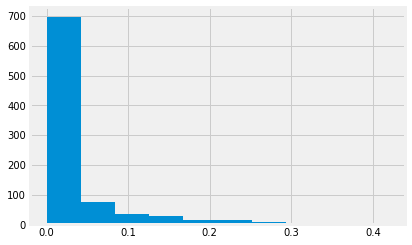

In [31]:
%%time
#Miss=claim_wide.isnull().sum(axis=0)
Miss=pd.DataFrame([(x,y) for x,y in rx_claim_wide_Total.isnull().sum(axis=0).items()],columns=['GENERIC_NAME','Miss_Count'])
Miss['Non_Miss_Per']=1-Miss['Miss_Count']/rx_claim_wide_Total.shape[0]
#Keep_Proc=list(Miss[Miss.Miss_Per<0.05].HCPCS_CODE)
Miss.Non_Miss_Per.hist()

### C.Choose a cut-off and only choose the most common drugs

If we consider drug one by one, we need to filter the drug with too many missing rows(At least Non-Missing>=2.5%). The reason we choose 2.5% as cut-off due to the cardilogist rate (2.48%)

**Show the drugs with non-missing percentage no smaller than 2.5%**

In [32]:
pd.set_option('display.max_rows', None)
Keep_Drug=list(Miss.sort_values(by=['Non_Miss_Per'],ascending=False)[Miss.Non_Miss_Per>=0.025].GENERIC_NAME)
Miss.sort_values(by=['Non_Miss_Per'],ascending=False)[Miss.Non_Miss_Per>=0.025]

,GENERIC_NAME,Miss_Count,Non_Miss_Per
401,HYDROCODONE/ACETAMINOPHEN,469073,0.418974
493,LISINOPRIL,540462,0.330546
621,OMEPRAZOLE,548101,0.321084
41,AMLODIPINE BESYLATE,554802,0.312784
754,SIMVASTATIN,564872,0.300310
375,GABAPENTIN,568717,0.295548
481,LEVOTHYROXINE SODIUM,570668,0.293131
374,FUROSEMIDE,572707,0.290605
64,ATORVASTATIN CALCIUM,579671,0.281979
543,METOPROLOL TARTRATE,586409,0.273633


In [33]:
print('There are {} drugs with non-missing percentage no smaller than 2.5% and displayed above'.format(len(Keep_Drug)))

There are 242 drugs with non-missing percentage no smaller than 2.5% and displayed above


### D.Generate aggrigate wide-format drug features for modeling

**Only look at these 242 drugs**

In [34]:
rx_claim_wide_Total=rx_claim_wide_Total[rx_claim_wide_Total.columns[rx_claim_wide_Total.columns.isin(Keep_Drug)]].fillna(0)

In [35]:
rx_claim_wide_Total=rx_claim_wide_Total.reset_index()

## Get the merged table with outcomes and corresponding procedure and drug columns

We get the outcome table provider and feature tables rx_claim_wide_Total and NPI_Model. In this section, we will merge them into one table for next-steps feature engineering.

In [36]:
Merge_Dta=provider.merge(NPI_Model,how='inner').merge(rx_claim_wide_Total,how='inner')

In [37]:
Merge_Dta.head()

,NPI,cardi_flag,Anes,skin,Asp,Insert_Vein,Ear,CT_head,Xray_chest,Xray_spline,...,TRIAMTERENE/HYDROCHLOROTHIAZID,VALACYCLOVIR HCL,VALSARTAN,VALSARTAN/HYDROCHLOROTHIAZIDE,VENLAFAXINE HCL,VERAPAMIL HCL,WARFARIN SODIUM,ZIPRASIDONE HCL,ZOLPIDEM TARTRATE,ZOSTER VACCINE LIVE/PF
0,1003000126,0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0
1,1003000142,0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1003000407,0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1003000423,0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1003000522,0,0.0,0.0,1.166667,0.0,1.142857,0.0,0.0,0.0,...,43.0,0.0,0.0,22.0,0.0,29.0,66.0,0.0,65.0,0.0


**Cardiologist rate**

In [38]:
Merge_Dta.cardi_flag.sum()/Merge_Dta.shape[0]

0.039525473910799525

Cardiologist rate is 3.95% among 544459 providers

In [39]:
del NPI_Model,rx_claim_wide_Total,provider

**Delete raw data**

In [55]:
del claim,rx_claim,HCPC,provider

NameError: name 'claim' is not defined

## Feature Analysis, Engineering and Selection

There are 300 features generated from procedure codes and drugs. Thus we need to do some analysis on features and select candidate features for modeling

* **Calculate the Cardiologist rate**
* **Remove low frequency variables**
* **Remove the variables that are not significant by single logstic regression (p value<0.05)**
* **Check multicollinearity among remaining features**
* **Further narrow down the numbers of features using random forest**
* **Visulization of selected features**

### Calculate Cardiologist rate

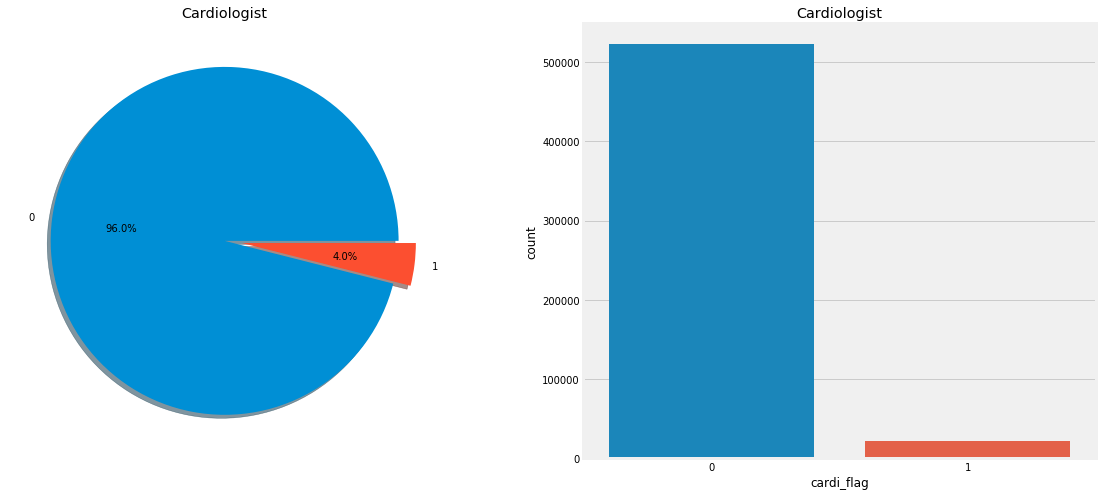

In [41]:
f,ax=plt.subplots(1,2,figsize=(18,8))
Merge_Dta['cardi_flag'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Cardiologist')
ax[0].set_ylabel('')
sns.countplot('cardi_flag',data=Merge_Dta,ax=ax[1])
ax[1].set_title('Cardiologist')
plt.show()

### Remove low variance features

We consider all features as continuous. We first filter the features by calculating their variance. If the variance is too low, we will remove them.

In [42]:
Model=Merge_Dta.copy()

In [43]:
def get_low_variance(df,thresh=0.0):
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.number):
            value_counts= np.nanvar(pd.to_numeric(df[col])) # directly remove NA
            if (value_counts<=thresh):
                df.drop(col, axis=1,inplace=True)
            else:
                df=df
    return df 

In [44]:
Model=get_low_variance(Model,thresh=0.1)

In [45]:
Model=Model.merge(Merge_Dta[['NPI','cardi_flag']])

In [49]:
Model.shape

(544459, 273)

In [46]:
#import scipy.stats as stats
#import researchpy as rp
#import statsmodels.api as sm

In [47]:
#sns.set(rc={'figure.figsize':(12,8)})
#sns.distplot(Model[Model.cardi_flag==1]['FLUOXETINE HCL'], color="skyblue", label="Enroll")
#sns.distplot(Model[Model.cardi_flag==0]['FLUOXETINE HCL'], color="red", label="Non-Enroll")
#sns.legend()

In [54]:
Model.to_pickle('Model_Data_Update.pkl')

### Remove the variables that are not significant by single logstic regression (p value<0.05)

In [51]:
colToKeep = []
for i, column in enumerate(Model.columns[2:-1]):
    ##formula = "cardi_flag ~ " + column
    model = sm.Logit(Model['cardi_flag'],Model[column])
    results = model.fit()
    if results.pvalues[0]< 0.05:
        colToKeep.append(column)

Optimization terminated successfully.
         Current function value: 0.637994
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.604055
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.617927
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.663039
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.576294
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.652021
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.653671
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.677620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617927

In [52]:
len(colToKeep)

270

No features are removed and are all significant. 

### Check multicollinearity among remaining features

**Heatmap of features from procedure claim data**

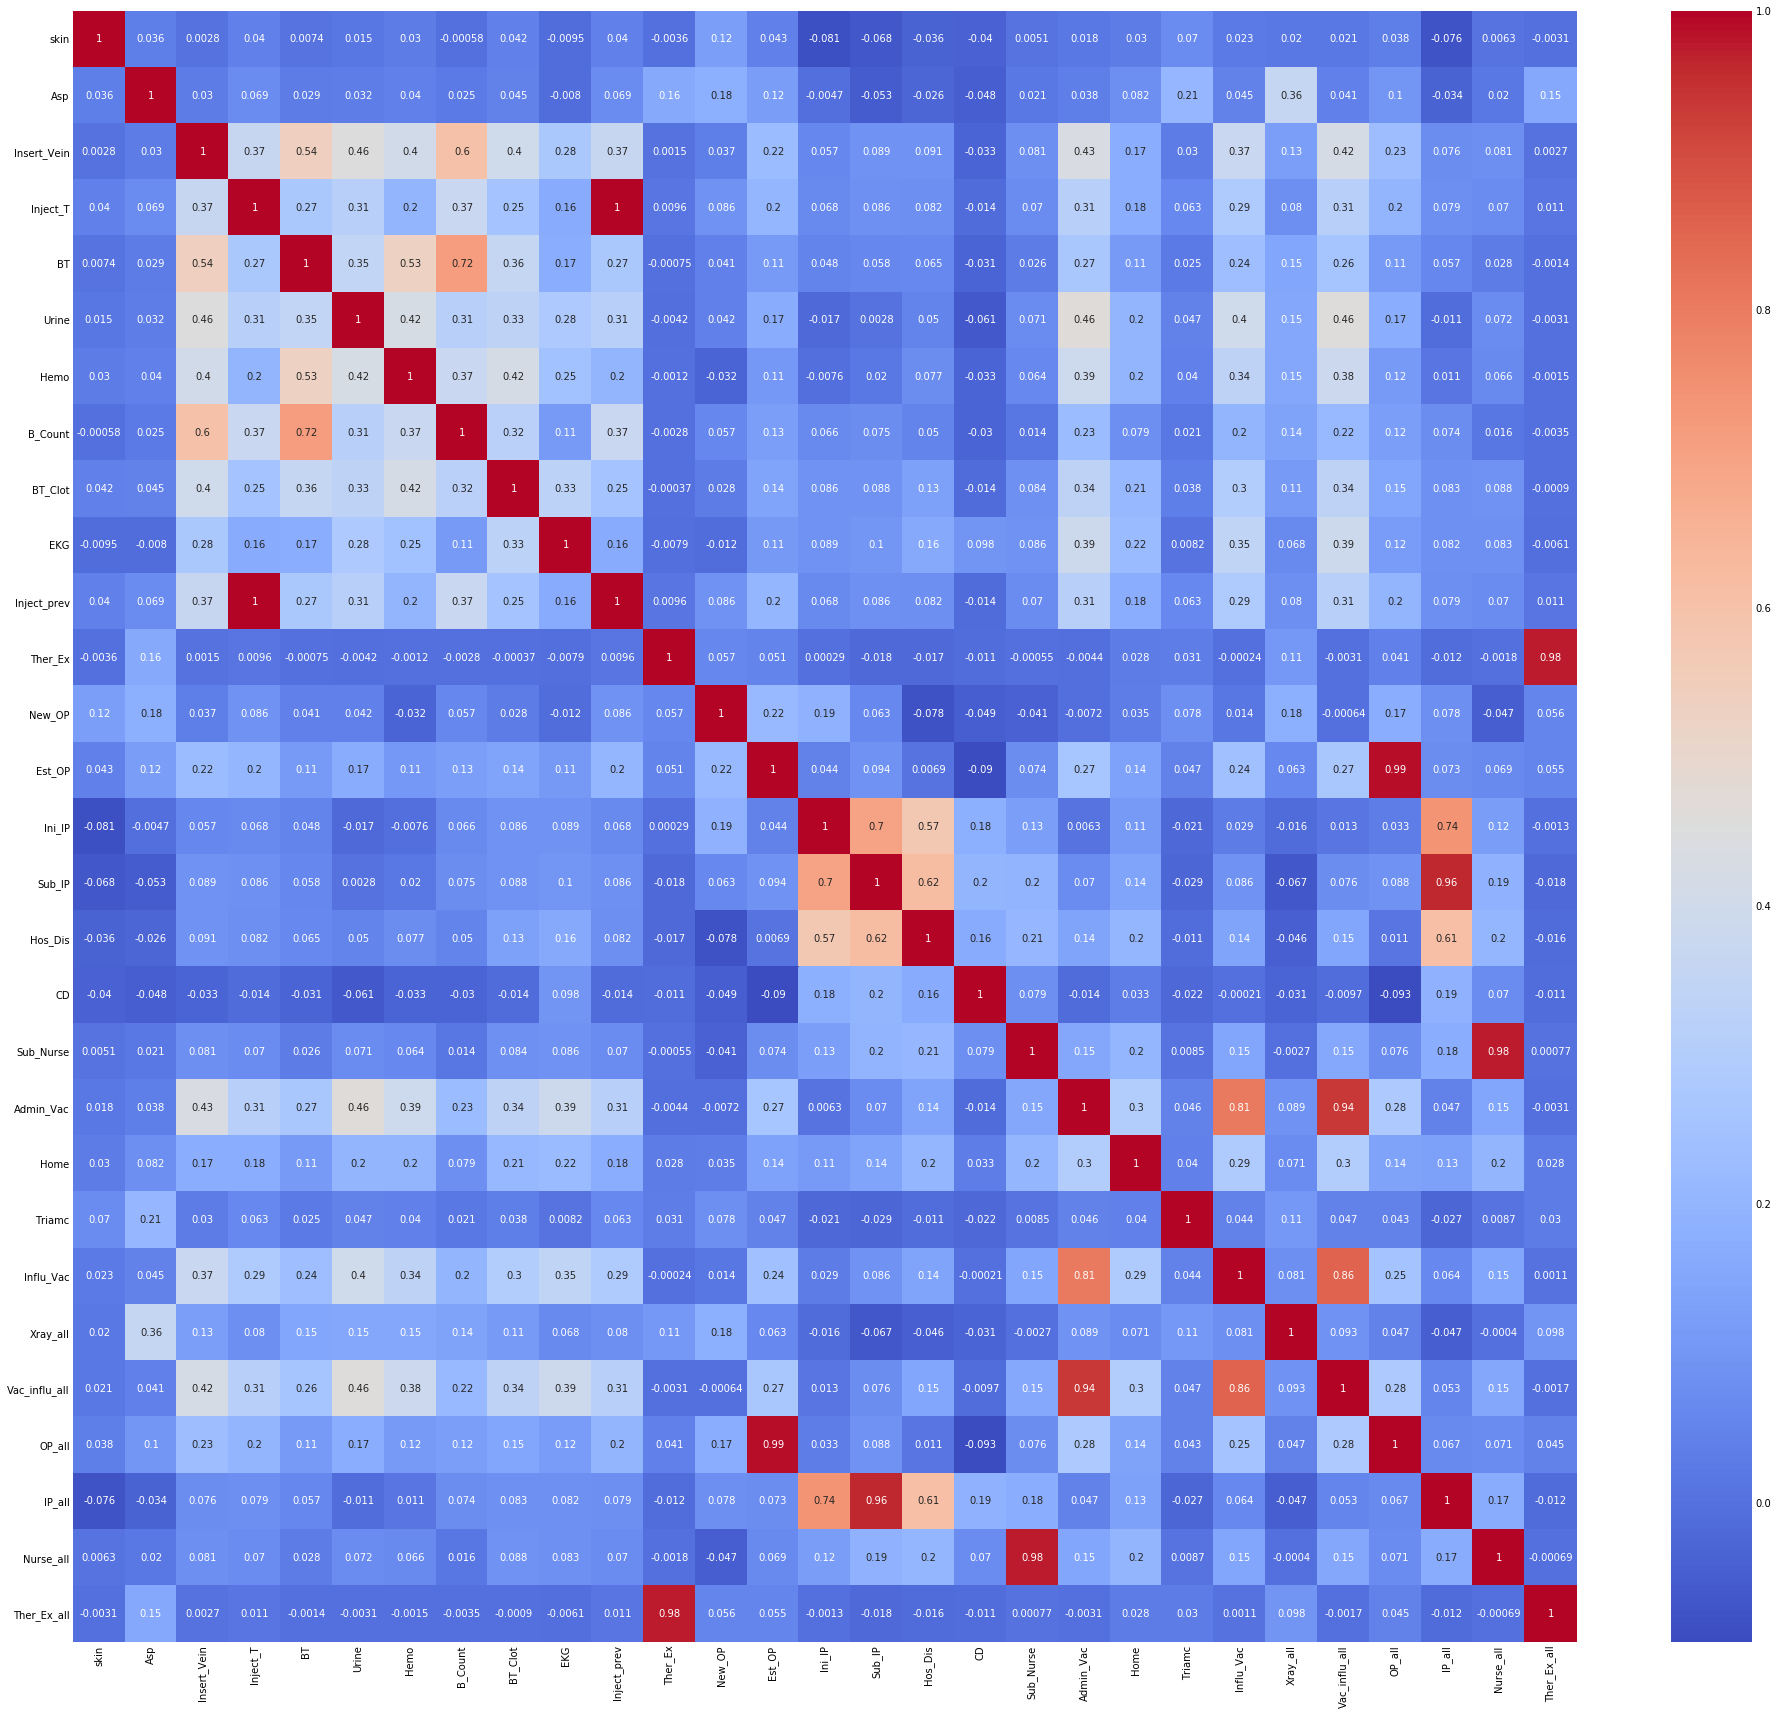

In [58]:
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(Model.loc[:,['skin', 'Asp', 'Insert_Vein', 'Inject_T', 'BT', 'Urine',
       'Hemo', 'B_Count', 'BT_Clot', 'EKG', 'Inject_prev', 'Ther_Ex',
       'New_OP', 'Est_OP', 'Ini_IP', 'Sub_IP', 'Hos_Dis', 'CD',
       'Sub_Nurse', 'Admin_Vac', 'Home', 'Triamc', 'Influ_Vac',
       'Xray_all', 'Vac_influ_all', 'OP_all', 'IP_all', 'Nurse_all',
       'Ther_Ex_all']].corr(), annot=True,cmap='coolwarm', xticklabels=True, yticklabels=True, ax=ax)

**Remove features with correlation>0.85**

In [59]:
Model.drop(['Inject_T','Ther_Ex','Est_OP','Sub_IP','Sub_Nurse','Admin_Vac','Influ_Vac'],axis=1,inplace=True)

There are too many drug-related features and it is hard to directly see the correlation in heatmap. We will calculate correlation and drop the high correlated features

**Correlation of features from pharmacy claim data**

In [5]:
Drug_A=['ACETAMINOPHEN WITH CODEINE', 'ACYCLOVIR',
       'ALBUTEROL SULFATE', 'ALENDRONATE SODIUM', 'ALLOPURINOL',
       'ALPRAZOLAM', 'AMIODARONE HCL', 'AMITRIPTYLINE HCL',
       'AMLODIPINE BESYLATE', 'AMLODIPINE BESYLATE/BENAZEPRIL',
       'AMLODIPINE/VALSARTAN', 'AMOXICILLIN',
       'AMOXICILLIN/POTASSIUM CLAV', 'ARIPIPRAZOLE',
       'ASPIRIN/DIPYRIDAMOLE', 'ATENOLOL', 'ATENOLOL/CHLORTHALIDONE',
       'ATORVASTATIN CALCIUM', 'AZITHROMYCIN']
Drug_B_C=['BACLOFEN',
       'BENAZEPRIL HCL', 'BENZTROPINE MESYLATE', 'BIMATOPROST',
       'BISOPROLOL FUMARATE/HCTZ', 'BRIMONIDINE TARTRATE',
       'BUDESONIDE/FORMOTEROL FUMARATE', 'BUMETANIDE', 'BUPROPION HCL',
       'BUSPIRONE HCL', 'CALCITRIOL', 'CARBAMAZEPINE',
       'CARBIDOPA/LEVODOPA', 'CARISOPRODOL', 'CARVEDILOL',
       'CEFUROXIME AXETIL', 'CELECOXIB', 'CEPHALEXIN',
       'CHLORHEXIDINE GLUCONATE', 'CHLORTHALIDONE', 'CILOSTAZOL',
       'CIPROFLOXACIN HCL', 'CITALOPRAM HYDROBROMIDE', 'CLINDAMYCIN HCL',
       'CLOBETASOL PROPIONATE', 'CLONAZEPAM', 'CLONIDINE HCL',
       'CLOPIDOGREL BISULFATE', 'CLOTRIMAZOLE/BETAMETHASONE DIP',
       'COLCHICINE', 'COLESEVELAM HCL', 'CYCLOBENZAPRINE HCL',
       'CYCLOSPORINE']
Drug_D_E=['DABIGATRAN ETEXILATE MESYLATE', 'DEXLANSOPRAZOLE',
       'DEXTROAMPHETAMINE/AMPHETAMINE', 'DIAZEPAM', 'DICLOFENAC SODIUM',
       'DICYCLOMINE HCL', 'DIGOXIN', 'DILTIAZEM HCL',
       'DIPHENOXYLATE HCL/ATROPINE', 'DIVALPROEX SODIUM', 'DONEPEZIL HCL',
       'DORZOLAMIDE HCL/TIMOLOL MALEAT', 'DOXAZOSIN MESYLATE',
       'DOXEPIN HCL', 'DOXYCYCLINE HYCLATE', 'DULOXETINE HCL',
       'DUTASTERIDE', 'ENALAPRIL MALEATE', 'ESCITALOPRAM OXALATE',
       'ESOMEPRAZOLE MAGNESIUM', 'ESTRADIOL', 'ESTROGENS, CONJUGATED',
       'ESZOPICLONE', 'EZETIMIBE', 'EZETIMIBE/SIMVASTATIN']
Drug_F_H=['FAMOTIDINE',
       'FELODIPINE', 'FENOFIBRATE', 'FENOFIBRATE NANOCRYSTALLIZED',
       'FENOFIBRATE,MICRONIZED', 'FENTANYL', 'FINASTERIDE', 'FLUCONAZOLE',
       'FLUOXETINE HCL', 'FLUTICASONE PROPIONATE',
       'FLUTICASONE/SALMETEROL', 'FUROSEMIDE', 'GABAPENTIN',
       'GEMFIBROZIL', 'GLIMEPIRIDE', 'GLIPIZIDE', 'GLYBURIDE',
       'GLYBURIDE/METFORMIN HCL', 'HALOPERIDOL',
       'HUM INSULIN NPH/REG INSULIN HM', 'HYDRALAZINE HCL',
       'HYDROCHLOROTHIAZIDE', 'HYDROCODONE/ACETAMINOPHEN',
       'HYDROCORTISONE', 'HYDROMORPHONE HCL',
       'HYDROXYCHLOROQUINE SULFATE', 'HYDROXYZINE HCL',
       'HYDROXYZINE PAMOATE']
Drug_I_L=['IBANDRONATE SODIUM', 'IBUPROFEN',
       'INSULIN ASPART', 'INSULIN DETEMIR',
       'INSULIN GLARGINE,HUM.REC.ANLOG', 'INSULIN LISPRO',
       'INSULIN REGULAR, HUMAN', 'INSULN ASP PRT/INSULIN ASPART',
       'IPRATROPIUM BROMIDE', 'IPRATROPIUM/ALBUTEROL SULFATE',
       'IRBESARTAN', 'ISOSORBIDE DINITRATE', 'ISOSORBIDE MONONITRATE',
       'KETOCONAZOLE', 'LABETALOL HCL', 'LACTULOSE', 'LAMOTRIGINE',
       'LANSOPRAZOLE', 'LATANOPROST', 'LEVETIRACETAM', 'LEVOFLOXACIN',
       'LEVOTHYROXINE SODIUM', 'LIDOCAINE', 'LISINOPRIL',
       'LISINOPRIL/HYDROCHLOROTHIAZIDE', 'LITHIUM CARBONATE', 'LORAZEPAM',
       'LOSARTAN POTASSIUM', 'LOSARTAN/HYDROCHLOROTHIAZIDE', 'LOVASTATIN']
Drug_M_N=['MECLIZINE HCL', 'MEGESTROL ACETATE', 'MELOXICAM', 'MEMANTINE HCL',
       'METFORMIN HCL', 'METHADONE HCL', 'METHOCARBAMOL',
       'METHOTREXATE SODIUM', 'METHYLPREDNISOLONE', 'METOCLOPRAMIDE HCL',
       'METOLAZONE', 'METOPROLOL SUCCINATE', 'METOPROLOL TARTRATE',
       'METRONIDAZOLE', 'MIRTAZAPINE', 'MOMETASONE FUROATE',
       'MONTELUKAST SODIUM', 'MORPHINE SULFATE', 'MUPIROCIN',
       'NABUMETONE', 'NAPROXEN', 'NEBIVOLOL HCL',
       'NEEDLES, INSULIN DISPOSABLE', 'NIACIN', 'NIFEDIPINE',
       'NITROFURANTOIN MACROCRYSTAL', 'NITROFURANTOIN MONOHYD/M-CRYST',
       'NITROGLYCERIN', 'NORTRIPTYLINE HCL',
       'NPH, HUMAN INSULIN ISOPHANE', 'NYSTATIN']
Drug_O_P=['OLANZAPINE',
       'OLMESARTAN MEDOXOMIL', 'OLMESARTAN/HYDROCHLOROTHIAZIDE',
       'OLOPATADINE HCL', 'OMEGA-3 ACID ETHYL ESTERS', 'OMEPRAZOLE',
       'ONDANSETRON HCL', 'OXCARBAZEPINE', 'OXYBUTYNIN CHLORIDE',
       'OXYCODONE HCL', 'OXYCODONE HCL/ACETAMINOPHEN',
       'PANTOPRAZOLE SODIUM', 'PAROXETINE HCL', 'PHENOBARBITAL',
       'PHENYTOIN SODIUM EXTENDED', 'PIOGLITAZONE HCL',
       'POLYETHYLENE GLYCOL 3350', 'POTASSIUM CHLORIDE',
       'PRAMIPEXOLE DI-HCL', 'PRAVASTATIN SODIUM', 'PREDNISOLONE ACETATE',
       'PREDNISONE', 'PREGABALIN', 'PRIMIDONE', 'PROMETHAZINE HCL',
       'PROPRANOLOL HCL']
Drug_Q_S=['QUETIAPINE FUMARATE', 'QUINAPRIL HCL',
       'RALOXIFENE HCL', 'RAMIPRIL', 'RANITIDINE HCL', 'RANOLAZINE',
       'RISEDRONATE SODIUM', 'RISPERIDONE', 'RIVAROXABAN', 'RIVASTIGMINE',
       'ROPINIROLE HCL', 'ROSUVASTATIN CALCIUM', 'SAXAGLIPTIN HCL',
       'SERTRALINE HCL', 'SIMVASTATIN', 'SITAGLIPTIN PHOS/METFORMIN HCL',
       'SITAGLIPTIN PHOSPHATE', 'SOLIFENACIN SUCCINATE', 'SOTALOL HCL',
       'SPIRONOLACTONE', 'SUCRALFATE', 'SULFAMETHOXAZOLE/TRIMETHOPRIM',
       'SUMATRIPTAN SUCCINATE', 'SYRING W-NDL,DISP,INSUL,0.5ML',
       'SYRINGE & NEEDLE,INSULIN,1 ML']
Drug_T_Z=['TAMSULOSIN HCL', 'TEMAZEPAM',
       'TERAZOSIN HCL', 'THEOPHYLLINE ANHYDROUS', 'TIMOLOL MALEATE',
       'TIOTROPIUM BROMIDE', 'TIZANIDINE HCL', 'TOLTERODINE TARTRATE',
       'TOPIRAMATE', 'TORSEMIDE', 'TRAMADOL HCL',
       'TRAMADOL HCL/ACETAMINOPHEN', 'TRAVOPROST', 'TRAZODONE HCL',
       'TRIAMCINOLONE ACETONIDE', 'TRIAMTERENE/HYDROCHLOROTHIAZID',
       'VALACYCLOVIR HCL', 'VALSARTAN', 'VALSARTAN/HYDROCHLOROTHIAZIDE',
       'VENLAFAXINE HCL', 'VERAPAMIL HCL', 'WARFARIN SODIUM',
       'ZIPRASIDONE HCL', 'ZOLPIDEM TARTRATE', 'ZOSTER VACCINE LIVE/PF']

In [3]:
#Model.to_pickle('Model_Data_Continue.pkl')

In [6]:
#Model=pd.read_pickle("Model_Data_Continue.pkl")

In [8]:
#Model_Drug=Model.loc[:,Drug_A+Drug_B_C+Drug_D_E+Drug_F_H+Drug_I_L+Drug_M_N+Drug_O_P+Drug_Q_S+Drug_T_Z]
#Model_Drug['Intercept']=1
#vif = pd.DataFrame()
#vif["VIF_Factor"] = [variance_inflation_factor(Model_Drug.values, i) for i in range(Model_Drug.shape[1])]
#vif["features"] = Model_Drug.columns

**Drop any columns with greater than .85 corr**

In [7]:
#drop any columns with greater than .95 corr
corr_matrix = Model.loc[:,Drug_A+Drug_B_C+Drug_D_E+Drug_F_H+Drug_I_L+Drug_M_N+Drug_O_P+Drug_Q_S+Drug_T_Z].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [8]:
to_drop = [column for column in upper.columns if any(upper[column] >=0.85)]
to_drop

['MEMANTINE HCL', 'METHOTREXATE SODIUM', 'POTASSIUM CHLORIDE']

In [9]:
Model.drop(['MEMANTINE HCL', 'METHOTREXATE SODIUM', 'POTASSIUM CHLORIDE'],axis=1,inplace=True)

### Further narrow down the numbers of features using Random forest

**Random Forest**

In [10]:
## Import the random forest model.
rf = RandomForestClassifier() 
rf.fit(Model.iloc[:,1:-1], Model.iloc[:,-1]) 
rf.score(Model.iloc[:,1:-1], Model.iloc[:,-1])

0.999921022519602

In [11]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = Model.iloc[:,1:-1].columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [18]:
Feature_RF=feature_importances[:25]

In [19]:
Feature_RF.index

Index(['EKG', 'GABAPENTIN', 'CARVEDILOL', 'CLOPIDOGREL BISULFATE',
       'ISOSORBIDE MONONITRATE', 'METFORMIN HCL', 'METOPROLOL SUCCINATE',
       'AMIODARONE HCL', 'RIVAROXABAN', 'NITROGLYCERIN',
       'LEVOTHYROXINE SODIUM', 'DABIGATRAN ETEXILATE MESYLATE', 'OMEPRAZOLE',
       'DIGOXIN', 'SOTALOL HCL', 'Ini_IP', 'OP_all', 'RANOLAZINE', 'IP_all',
       'New_OP', 'FLUTICASONE PROPIONATE', 'INSULIN GLARGINE,HUM.REC.ANLOG',
       'CIPROFLOXACIN HCL', 'METOPROLOL TARTRATE', 'PREDNISONE'],
      dtype='object')

We keep the top 25 features

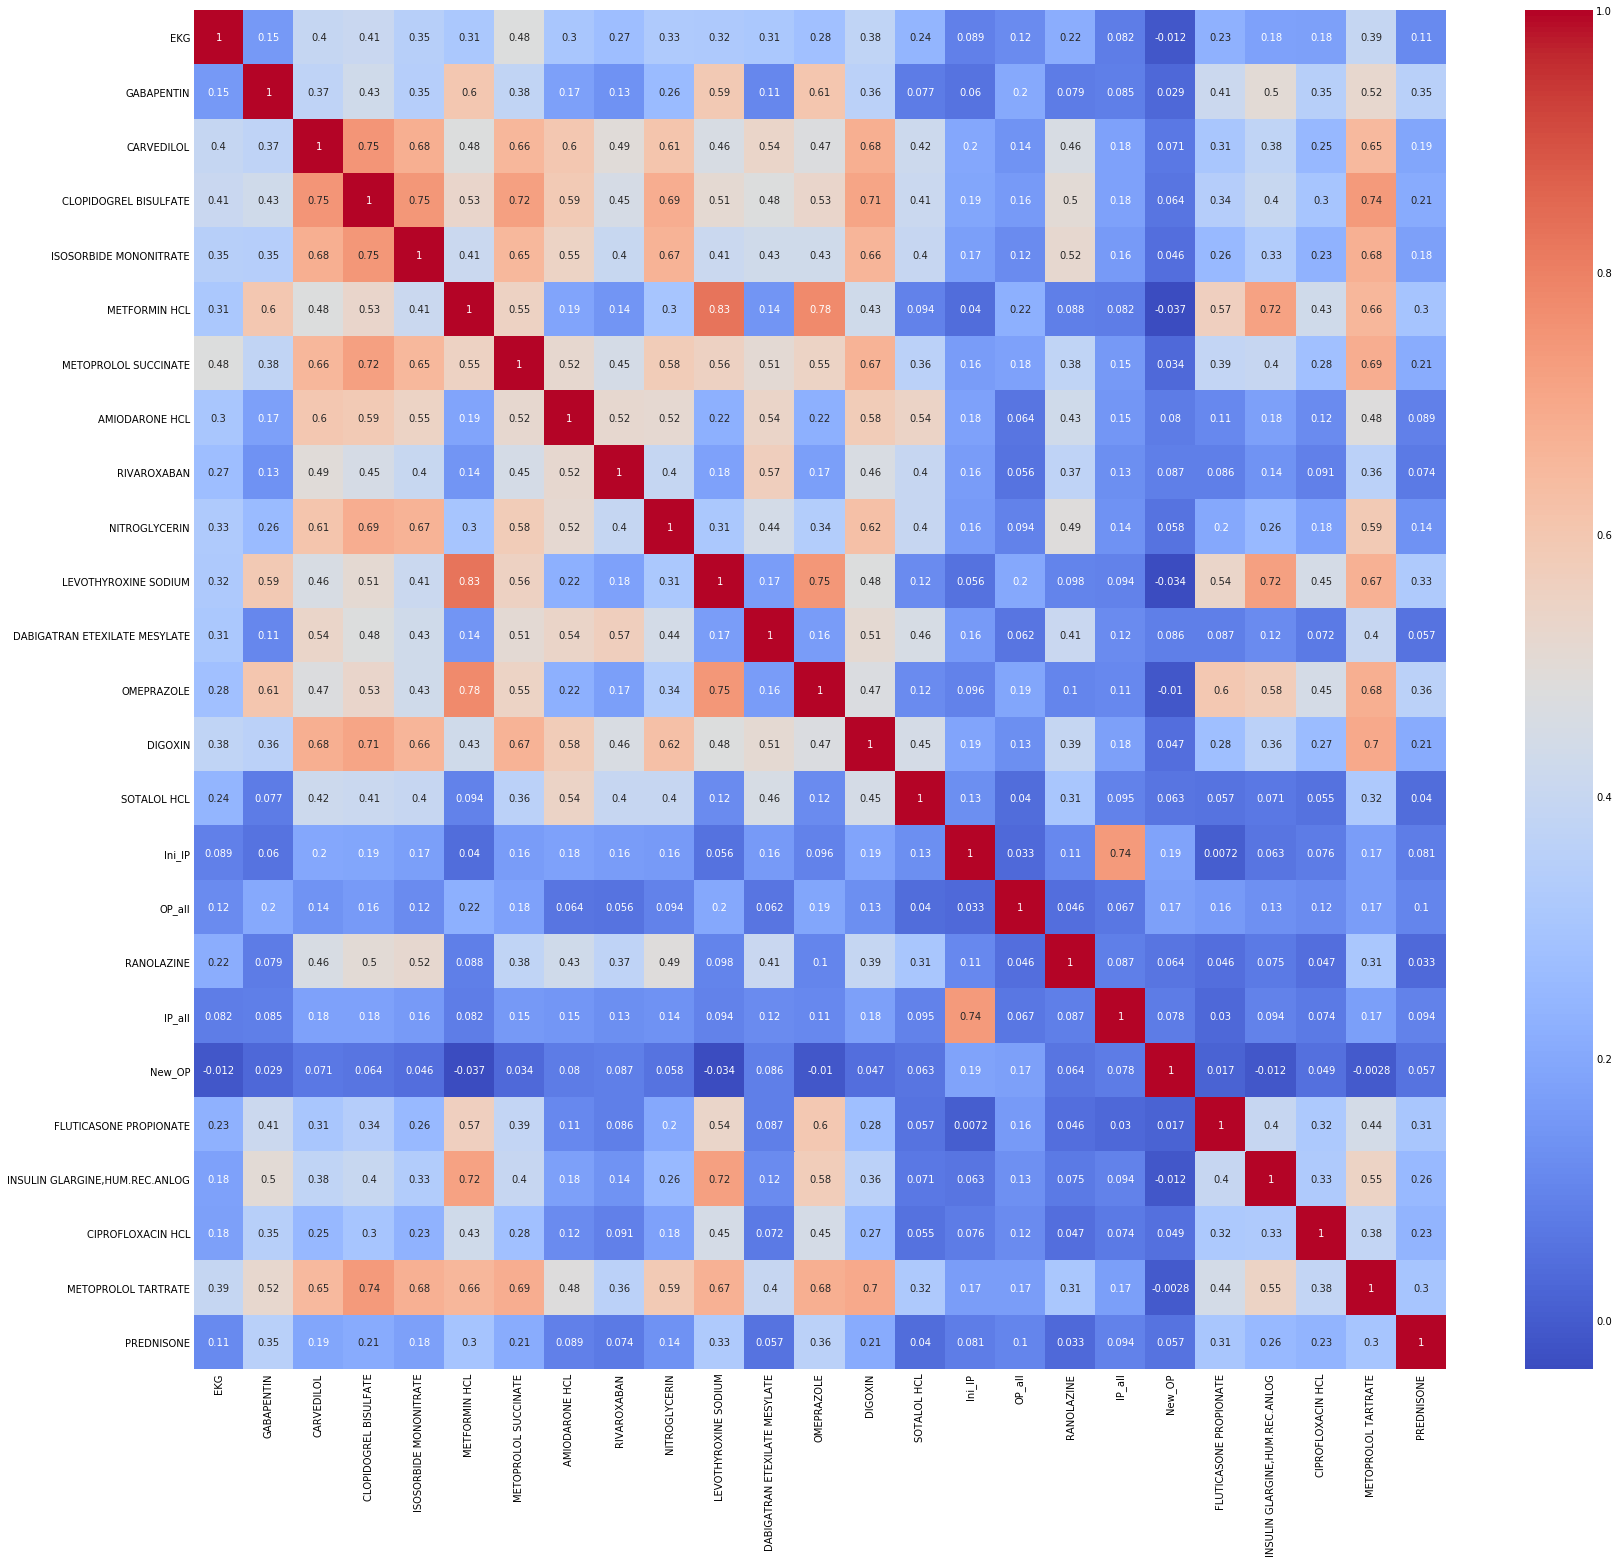

In [21]:
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(Model.loc[:,['EKG', 'GABAPENTIN', 'CARVEDILOL', 'CLOPIDOGREL BISULFATE',
       'ISOSORBIDE MONONITRATE', 'METFORMIN HCL', 'METOPROLOL SUCCINATE',
       'AMIODARONE HCL', 'RIVAROXABAN', 'NITROGLYCERIN',
       'LEVOTHYROXINE SODIUM', 'DABIGATRAN ETEXILATE MESYLATE', 'OMEPRAZOLE',
       'DIGOXIN', 'SOTALOL HCL', 'Ini_IP', 'OP_all', 'RANOLAZINE', 'IP_all',
       'New_OP', 'FLUTICASONE PROPIONATE', 'INSULIN GLARGINE,HUM.REC.ANLOG',
       'CIPROFLOXACIN HCL', 'METOPROLOL TARTRATE', 'PREDNISONE']].corr(), annot=True,cmap='coolwarm', xticklabels=True, yticklabels=True, ax=ax)

In [27]:
Model_Final=Model.loc[:,['cardi_flag','EKG', 'GABAPENTIN', 'CARVEDILOL', 'CLOPIDOGREL BISULFATE',
       'ISOSORBIDE MONONITRATE', 'METFORMIN HCL', 'METOPROLOL SUCCINATE',
       'AMIODARONE HCL', 'RIVAROXABAN', 'NITROGLYCERIN',
       'LEVOTHYROXINE SODIUM', 'DABIGATRAN ETEXILATE MESYLATE', 'OMEPRAZOLE',
       'DIGOXIN', 'SOTALOL HCL', 'Ini_IP', 'OP_all', 'RANOLAZINE', 'IP_all',
       'New_OP', 'FLUTICASONE PROPIONATE', 'INSULIN GLARGINE,HUM.REC.ANLOG',
       'CIPROFLOXACIN HCL', 'METOPROLOL TARTRATE', 'PREDNISONE']]

In [29]:
del Model

## Apply Machine Learning Methods and Model Comparisons and Evaluations

Next we will try several different classification methods considering the computing time

* **Lasso logistic regression**
* **Random Forest**

**Split the dataset**

In [32]:
train,test=train_test_split(Model_Final,test_size=0.3,random_state=0,stratify=Model_Final['cardi_flag'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=Model_Final[Model_Final.columns[1:]]
Y=Model_Final['cardi_flag']

### Lasso logistic regression

**scale your data**

In [82]:
#Scale your data
scaler = StandardScaler()
scaler.fit(train_X) 
train_X_scaled = pd.DataFrame(scaler.transform(train_X),columns = train_X.columns)
test_X_scaled = pd.DataFrame(scaler.transform(test_X),columns = test_X.columns)

**Grid search**

We use f1 instead of accuracy since it is an imbalanced data

In [53]:
grid={"C":[0.01,0.1,1,10], "penalty": ["l1"],'solver': ['liblinear','saga']}
lasso=GridSearchCV(LogisticRegression(),grid,n_jobs=-1,verbose=True,scoring='f1')
lasso.fit(train_X_scaled,train_Y)
print(lasso.best_score_)
print(lasso.best_estimator_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.5min finished


0.8104821592222613
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [55]:
lasso_final=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
lasso_final.fit(train_X_scaled,train_Y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [77]:
coefficients = pd.concat([pd.DataFrame(train_X_scaled.columns,columns=['Feature']),pd.DataFrame(np.transpose(lasso_final.coef_),columns=['Weight'])], axis = 1)

In [81]:
coefficients.sort_values('Weight',ascending=False)

,Feature,Weight
0,EKG,1.357476
15,Ini_IP,0.613936
6,METOPROLOL SUCCINATE,0.444384
2,CARVEDILOL,0.423137
3,CLOPIDOGREL BISULFATE,0.413118
19,New_OP,0.400997
23,METOPROLOL TARTRATE,0.317721
13,DIGOXIN,0.141487
18,IP_all,0.116191
4,ISOSORBIDE MONONITRATE,0.092971


In [114]:
lasso_final.fit(train_X_scaled,train_Y)
p = lasso_final.predict_proba(test_X_scaled)[:, 1]
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(test_Y, p))
print("Average of precison-recall score: %.3f" % average_precision_score(test_Y, p))

Average of decision tree ROC-AUC score: 0.975
Average of precison-recall score: 0.851


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.85')

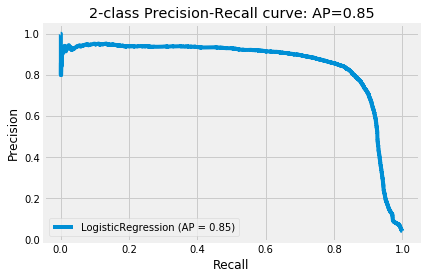

In [115]:
disp = plot_precision_recall_curve(lasso_final, test_X_scaled,test_Y)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision_score(test_Y, p)))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.98')

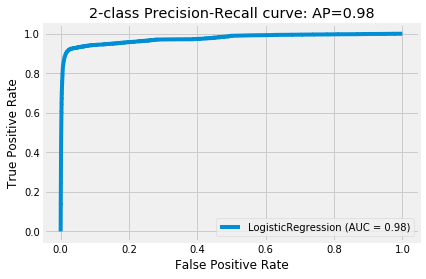

In [110]:
disp = plot_roc_curve(lasso_final, test_X_scaled,test_Y)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(roc_auc_score(test_Y, p)))

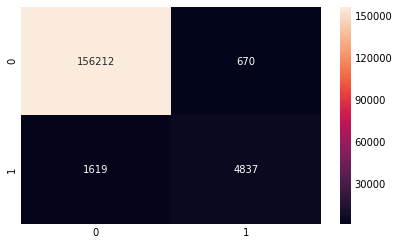

In [102]:
sns.heatmap(confusion_matrix(test_Y,(p>0.5).astype(int)),annot=True,fmt='2.0f')

If we set p>0.5, the precision is 0.878 and recall is 0.749. It is quite a good result

### Random Forest

In [66]:
grid={'n_estimators':[100],'max_depth':[5,10,15,20,25], 
                      'min_samples_split':[5]}
rf=GridSearchCV(RandomForestClassifier(),grid,n_jobs=-1,verbose=True,scoring='f1')
rf.fit(train_X,train_Y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [67]:
print(rf.best_score_)
print(rf.best_estimator_)

0.8718398656866799
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [111]:
rf_final=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rf_final.fit(train_X,train_Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [117]:
p = rf_final.predict_proba(test_X)[:, 1]
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(test_Y, p))
print("Average of precison-recall score: %.3f" % average_precision_score(test_Y, p))

Average of decision tree ROC-AUC score: 0.991
Average of precison-recall score: 0.918


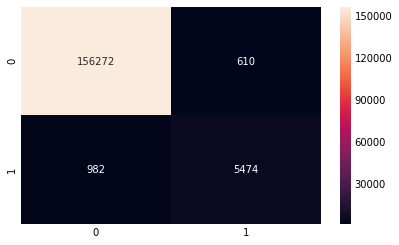

In [118]:
sns.heatmap(confusion_matrix(test_Y,(p>0.5).astype(int)),annot=True,fmt='2.0f')

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.92')

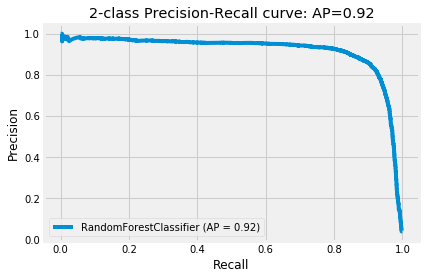

In [119]:
disp = plot_precision_recall_curve(rf_final, test_X,test_Y)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision_score(test_Y, p)))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.99')

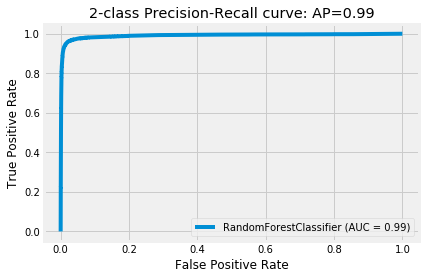

In [122]:
disp = plot_roc_curve(rf_final, test_X,test_Y)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(roc_auc_score(test_Y, p)))

**Random Forest has higher performance than lasso logistic regression**

We can have a look at what features are important

Text(0.5, 1.0, 'Feature Importance in Random Forests')

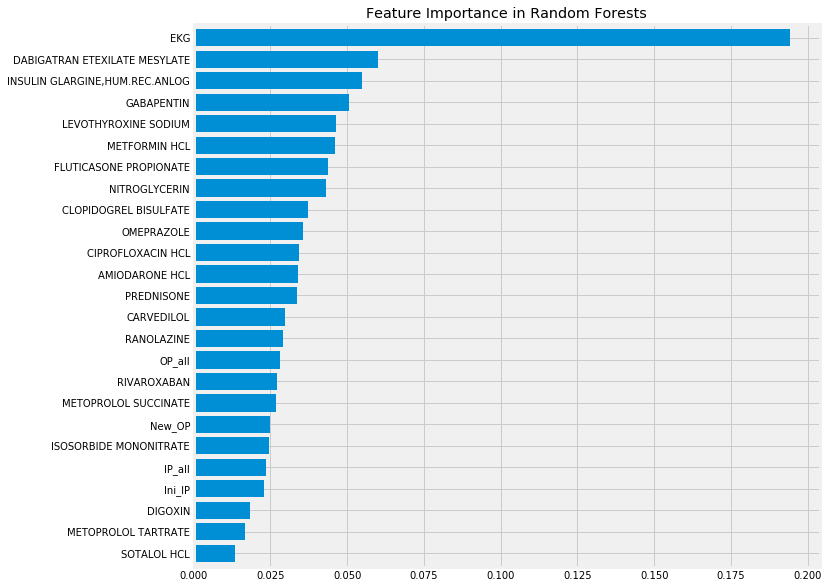

In [125]:
fig, ax = plt.subplots(figsize=(10,10))
ax=pd.Series(rf_final.feature_importances_,test_X.columns).sort_values(ascending=True).plot.barh(width=0.8)
ax.set_title('Feature Importance in Random Forests')

## Conclusion and Discussions

### Business Perspective

* The most important feature I found has dominate the classification result is average EKG procedures. The higher it is, the higher chance this provider is cardiologist. 
* Other postive features are avereage all_cause outpatient and inpatient visits from procedure claim data. 
* In terms of drugs, we found some drugs that may contribute to the prediction. Further analysis can be done with some domain knowledge support from clinical team.

### Data Perspective

* For pharmacy claim, we only have total drug numbers, the average number could be a better choice.
* More data information can come from cost, enrolled months from patients related to the providers and demographic information related to doctors.

### Methology Perspective

* We aggregate some features to reduce the number of features.
* Improvement can be done in drug features. With domain knowledge, we can aggregate the drug to groups and use group features for classification.
* Due to time limit, I only apply lasso logistic regression and random forest here. More advanced methods like Xgboosting and ensemble can be applied. In general, the results are quite good even using these baseline models
* This data is imbalanced dataset (3.9%), I don't consider balance the data. With more time, we can try oversampling or undersampling to balance the data and further improve the results. 